In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
import pandas as pd
from histr import Shabdansh
from typing import List

In [4]:
def get_top_n_names(data_path: str = '../naam.csv', n:int=32000) -> List[str]:
    names = pd.read_csv(data_path)
    names['name'] = names['name'].map(Shabdansh)
    # remove names with only one syllable
    names = names[names['name'].map(len) > 1]
    names['is_valid_name'] = names['name'].apply(lambda name: all(map(Shabdansh.is_valid_cluster, list(name))))
    names = names[names['is_valid_name']]
    words = names.sort_values(by=['count'], ascending=False)['name'][:32000].tolist()
    return words

In [5]:
# read in all the words
words = get_top_n_names()
words[:8]

/tmp/ipykernel_3686955/636747633.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  words = names.sort_values(by=['count'], ascending=False)['name'][:32000].tolist()


['राम',
 'पुत्र',
 'राजेन्द्र',
 'राजाराम',
 'ओमप्रकाश',
 'अब्दुल',
 'छोटेलाल',
 'सीताराम']

In [6]:
len(words)

32000

In [7]:
chars_ls = [list(name) for name in words]
chars = []
for ls in chars_ls:
    chars += ls

In [8]:
purna_virama = '।'
chars = sorted(list(set(chars)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[purna_virama] = 0
itos = {i:s for s,i in stoi.items()}
unique_syallable_count = len(stoi)
print(itos)

{1: 'अ', 2: 'अँ', 3: 'अं', 4: 'अा', 5: 'अॅ', 6: 'अो', 7: 'अौ', 8: 'आ', 9: 'आं', 10: 'आे', 11: 'आै', 12: 'इ', 13: 'इं', 14: 'ई', 15: 'उ', 16: 'ऊ', 17: 'ऊं', 18: 'ऋ', 19: 'ऋृ', 20: 'ए', 21: 'एै', 22: 'ऐ', 23: 'ओ', 24: 'ओं', 25: 'ओे', 26: 'ओै', 27: 'औ', 28: 'औं', 29: 'क', 30: 'कँ', 31: 'कं', 32: 'का', 33: 'कां', 34: 'कि', 35: 'किं', 36: 'की', 37: 'कु', 38: 'कुँ', 39: 'कुं', 40: 'कुॅ', 41: 'कू', 42: 'कृ', 43: 'के', 44: 'कै', 45: 'को', 46: 'कौ', 47: 'क्क', 48: 'क्का', 49: 'क्की', 50: 'क्कु', 51: 'क्कू', 52: 'क्के', 53: 'क्ख', 54: 'क्खा', 55: 'क्खि', 56: 'क्खी', 57: 'क्खु', 58: 'क्खू', 59: 'क्खे', 60: 'क्खो', 61: 'क्छे', 62: 'क्ट', 63: 'क्टू', 64: 'क्त', 65: 'क्ता', 66: 'क्ति', 67: 'क्ती', 68: 'क्ते', 69: 'क्फ', 70: 'क्म', 71: 'क्मा', 72: 'क्मि', 73: 'क्मी', 74: 'क्या', 75: 'क्यू', 76: 'क्र', 77: 'क्रा', 78: 'क्रां', 79: 'क्रि', 80: 'क्री', 81: 'क्रु', 82: 'क्रे', 83: 'क्ला', 84: 'क्श', 85: 'क्शी', 86: 'क्शू', 87: 'क्ष', 88: 'क्षा', 89: 'क्षि', 90: 'क्षी', 91: 'क्षु', 92: 'क्षू', 93: 'क्षे',

In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in list(w) + [purna_virama]:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([161660, 3]), torch.int64, torch.Size([161660]), torch.int64)

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in list(w) + [purna_virama]:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([129377, 3]) torch.Size([129377])
torch.Size([16142, 3]) torch.Size([16142])
torch.Size([16141, 3]) torch.Size([16141])


In [12]:
from jax import random
import jax
import jax.numpy as jnp

In [13]:
seed = 3247
key = random.PRNGKey(seed)

In [14]:
key, subkey = random.split(key)
emb_dim = 4
C = random.normal(subkey, (unique_syallable_count, emb_dim))

In [15]:
emb = C[X.numpy()]
emb.shape

(161660, 3, 4)

In [16]:
input_dim = block_size * emb_dim
key, subkey = random.split(key)
W1 = random.normal(subkey, (input_dim, 100))
key, subkey = random.split(key)
b1 = random.normal(subkey, (100,))

In [17]:
h = jnp.tanh(jnp.reshape(emb, (-1, input_dim)) @ W1 + b1)

In [18]:
h

Array([[-0.99999917, -0.3357381 , -0.6627387 , ..., -0.51442844,
         0.99985814,  0.99999905],
       [-0.9999999 ,  0.8000883 , -0.29285854, ...,  0.9998564 ,
         0.9999989 ,  0.9999997 ],
       [ 0.77132845,  0.6963416 , -0.99879885, ...,  0.9653315 ,
         0.9999463 ,  1.        ],
       ...,
       [ 0.51449394,  0.03411764,  0.9936334 , ...,  0.8788691 ,
        -0.99987423, -0.9999985 ],
       [ 0.63359416, -0.7670247 ,  0.9910385 , ...,  0.9832087 ,
         0.7493752 , -0.97653145],
       [ 0.9999961 , -0.9069117 , -0.9967712 , ...,  0.99782234,
        -0.9997591 , -0.9998818 ]], dtype=float32)

In [19]:
h.shape

(161660, 100)

In [20]:
key, subkey = random.split(key)
W2 = random.normal(subkey, (100, unique_syallable_count))
key, subkey = random.split(key)
b2 = random.normal(subkey, (unique_syallable_count,))

In [21]:
logits = h @ W2 + b2

In [22]:
logits.shape

(161660, 1296)

In [23]:
counts = jnp.exp(logits)

In [24]:
prob = counts / jnp.sum(counts, axis=1, keepdims=True)

In [25]:
prob.shape

(161660, 1296)

In [26]:
prob.shape

(161660, 1296)

In [27]:
loss = -jnp.mean(jnp.log(prob[jnp.arange(161660), Y.numpy()]))
loss

Array(30.216719, dtype=float32)

In [28]:
# ------------ now made respectable :) ---------------

In [29]:
from jax import random
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap

In [30]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([129377, 3]), torch.Size([129377]))

In [31]:
# Define the shapes of the parameters
emb_dim = 10
block_size = 3
input_dim = emb_dim * block_size
params_shapes = [(unique_syallable_count, emb_dim), (input_dim, 200), (200,), (200, unique_syallable_count), (unique_syallable_count,)]


In [40]:
# Initialize the parameters with random values
key = random.PRNGKey(2147483647)
params = []
for shape in params_shapes:
    key, subkey = random.split(key)
    params.append(random.normal(subkey, shape))

param_count = sum(x.size for x in jax.tree_leaves(params))
param_count

/tmp/ipykernel_3686955/4087364666.py:8: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  param_count = sum(x.size for x in jax.tree_leaves(params))


279656

In [38]:
# Define the loss function
def loss_fn(params, X, Y):
    C, W1, b1, W2, b2 = params
    emb = C[X]
    h = jnp.tanh(emb.reshape(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = -jnp.mean(jax.nn.log_softmax(logits)[jnp.arange(Y.shape[0]), Y], axis=-1)
    return loss

# Define the update function
@jit
def update(params, X, Y, lr):
    grad_fn = jit(grad(loss_fn))
    loss = loss_fn(params, X, Y)
    grads = grad_fn(params, X, Y)
    params = [p - lr * g for p, g in zip(params, grads)]
    return params, loss

In [34]:
# Convert the PyTorch tensors to numpy arrays
Xtr = np.array(Xtr)
Ytr = np.array(Ytr)

# Define the learning rate schedule
lre = jnp.linspace(-3, 0, 1000)
lrs = 10**lre

# Define the lists to store the training statistics
stepi = []
lossi = []

In [39]:
from jax_smi import initialise_tracking
initialise_tracking()

In [41]:
# Train the model
batch_size = 128
minibatch_count = 200000
for i in range(minibatch_count):
    # Select a minibatch
    ix = np.random.choice(Xtr.shape[0], size=batch_size, replace=False)
    X, Y = Xtr[ix], Ytr[ix]
    
    # Update the learning rate
    lr = 0.1 if i < 100000 else 0.01
    
    # Update the parameters and record the loss
    params, loss = update(params, X, Y, lr)
    if not i % 100:
        print(f"At Step {i}: {loss}")
    
    # Record the statistics
    stepi.append(i)
    lossi.append(jnp.log10(loss))

At Step 0: 46.25690841674805
At Step 100: 25.58892822265625
At Step 200: 20.533937454223633
At Step 300: 14.292768478393555
At Step 400: 13.650838851928711
At Step 500: 12.658585548400879
At Step 600: 11.728867530822754
At Step 700: 7.537524700164795
At Step 800: 8.911423683166504
At Step 900: 8.22096061706543
At Step 1000: 8.734426498413086
At Step 1100: 10.24441909790039
At Step 1200: 9.519014358520508
At Step 1300: 7.477259635925293
At Step 1400: 6.419981956481934
At Step 1500: 6.378137588500977
At Step 1600: 7.902013778686523
At Step 1700: 9.234561920166016
At Step 1800: 4.011430740356445
At Step 1900: 3.3279995918273926
At Step 2000: 8.199305534362793
At Step 2100: 6.811446666717529
At Step 2200: 6.0869059562683105
At Step 2300: 5.388810634613037
At Step 2400: 5.58750057220459
At Step 2500: 6.502692222595215
At Step 2600: 9.758950233459473
At Step 2700: 6.535094261169434
At Step 2800: 7.570211410522461
At Step 2900: 6.240434169769287
At Step 3000: 8.500484466552734
At Step 3100: 6

At Step 25100: 3.379417896270752
At Step 25200: 4.12541389465332
At Step 25300: 4.350745677947998
At Step 25400: 3.6134467124938965
At Step 25500: 3.6263444423675537
At Step 25600: 3.379509925842285
At Step 25700: 2.960209608078003
At Step 25800: 3.934976816177368
At Step 25900: 3.5745503902435303
At Step 26000: 4.363394260406494
At Step 26100: 4.533592224121094
At Step 26200: 4.04880952835083
At Step 26300: 4.046788692474365
At Step 26400: 3.674393892288208
At Step 26500: 3.722136974334717
At Step 26600: 3.749929189682007
At Step 26700: 4.212815761566162
At Step 26800: 3.198198080062866
At Step 26900: 4.650943756103516
At Step 27000: 3.452878475189209
At Step 27100: 3.761781930923462
At Step 27200: 4.027932167053223
At Step 27300: 4.320484161376953
At Step 27400: 3.257145881652832
At Step 27500: 3.535128593444824
At Step 27600: 3.760094165802002
At Step 27700: 3.865295886993408
At Step 27800: 5.108083248138428
At Step 27900: 3.458085536956787
At Step 28000: 2.6998894214630127
At Step 

At Step 49700: 3.0378243923187256
At Step 49800: 3.3883910179138184
At Step 49900: 3.639495849609375
At Step 50000: 3.054473876953125
At Step 50100: 3.944017171859741
At Step 50200: 3.4756970405578613
At Step 50300: 3.7895870208740234
At Step 50400: 3.6131744384765625
At Step 50500: 3.776479721069336
At Step 50600: 3.3691277503967285
At Step 50700: 3.353283643722534
At Step 50800: 3.781916856765747
At Step 50900: 2.8809125423431396
At Step 51000: 3.2873988151550293
At Step 51100: 3.048659324645996
At Step 51200: 3.5395917892456055
At Step 51300: 3.7054035663604736
At Step 51400: 3.3816535472869873
At Step 51500: 3.2840075492858887
At Step 51600: 4.179899215698242
At Step 51700: 3.2030632495880127
At Step 51800: 4.4466328620910645
At Step 51900: 3.916666030883789
At Step 52000: 3.9044344425201416
At Step 52100: 2.890242338180542
At Step 52200: 3.718411445617676
At Step 52300: 2.667410135269165
At Step 52400: 4.0735859870910645
At Step 52500: 3.6023056507110596
At Step 52600: 3.355551242

At Step 74300: 3.5488064289093018
At Step 74400: 4.00536584854126
At Step 74500: 3.58902907371521
At Step 74600: 2.781934976577759
At Step 74700: 4.2346086502075195
At Step 74800: 3.736724853515625
At Step 74900: 3.706399917602539
At Step 75000: 4.153158664703369
At Step 75100: 3.1510701179504395
At Step 75200: 3.008265256881714
At Step 75300: 3.269042730331421
At Step 75400: 3.6325106620788574
At Step 75500: 3.153519868850708
At Step 75600: 3.965346097946167
At Step 75700: 3.861891746520996
At Step 75800: 3.657684326171875
At Step 75900: 3.8790462017059326
At Step 76000: 3.8295722007751465
At Step 76100: 3.571453332901001
At Step 76200: 3.0848195552825928
At Step 76300: 3.5145957469940186
At Step 76400: 3.931889295578003
At Step 76500: 3.8472721576690674
At Step 76600: 3.207840919494629
At Step 76700: 3.2139718532562256
At Step 76800: 3.264996290206909
At Step 76900: 3.549278497695923
At Step 77000: 4.230810642242432
At Step 77100: 3.3410818576812744
At Step 77200: 4.60748815536499
At

At Step 98900: 3.985586404800415
At Step 99000: 3.7340705394744873
At Step 99100: 4.0103278160095215
At Step 99200: 3.7032217979431152
At Step 99300: 3.4276785850524902
At Step 99400: 3.708479642868042
At Step 99500: 2.5980286598205566
At Step 99600: 3.754019021987915
At Step 99700: 4.383589744567871
At Step 99800: 3.7109570503234863
At Step 99900: 4.142154693603516
At Step 100000: 3.212674617767334
At Step 100100: 3.9265527725219727
At Step 100200: 3.793560266494751
At Step 100300: 3.3858299255371094
At Step 100400: 3.708117961883545
At Step 100500: 3.9624125957489014
At Step 100600: 3.8798012733459473
At Step 100700: 4.289450645446777
At Step 100800: 4.140172481536865
At Step 100900: 4.064344882965088
At Step 101000: 3.7181575298309326
At Step 101100: 2.0576589107513428
At Step 101200: 3.3210883140563965
At Step 101300: 3.007417917251587
At Step 101400: 3.08626651763916
At Step 101500: 3.315747022628784
At Step 101600: 3.514854669570923
At Step 101700: 2.763181686401367
At Step 10180

At Step 122800: 3.940948963165283
At Step 122900: 3.654987096786499
At Step 123000: 2.964913845062256
At Step 123100: 3.7814743518829346
At Step 123200: 2.8895256519317627
At Step 123300: 2.3462414741516113
At Step 123400: 3.3621397018432617
At Step 123500: 2.806516170501709
At Step 123600: 4.0518012046813965
At Step 123700: 3.169159412384033
At Step 123800: 3.157864809036255
At Step 123900: 3.611490488052368
At Step 124000: 3.821425199508667
At Step 124100: 2.8176252841949463
At Step 124200: 3.3934013843536377
At Step 124300: 3.940187454223633
At Step 124400: 3.1486124992370605
At Step 124500: 2.8039915561676025
At Step 124600: 3.6317527294158936
At Step 124700: 3.7719287872314453
At Step 124800: 3.5536346435546875
At Step 124900: 3.778986692428589
At Step 125000: 4.254281997680664
At Step 125100: 3.0731191635131836
At Step 125200: 3.7638096809387207
At Step 125300: 4.050748348236084
At Step 125400: 2.7892191410064697
At Step 125500: 4.0180439949035645
At Step 125600: 3.54903388023376

At Step 146600: 3.4566550254821777
At Step 146700: 3.7342400550842285
At Step 146800: 2.8781981468200684
At Step 146900: 3.932701349258423
At Step 147000: 2.5595595836639404
At Step 147100: 3.8594377040863037
At Step 147200: 3.8050038814544678
At Step 147300: 3.8565595149993896
At Step 147400: 3.5425145626068115
At Step 147500: 3.2073252201080322
At Step 147600: 2.8943071365356445
At Step 147700: 3.9114723205566406
At Step 147800: 4.632791042327881
At Step 147900: 3.157043218612671
At Step 148000: 4.006307601928711
At Step 148100: 2.5717623233795166
At Step 148200: 3.982052803039551
At Step 148300: 4.326913833618164
At Step 148400: 3.2245099544525146
At Step 148500: 4.066866874694824
At Step 148600: 3.44571590423584
At Step 148700: 2.8401029109954834
At Step 148800: 4.090883255004883
At Step 148900: 4.384817123413086
At Step 149000: 3.9202075004577637
At Step 149100: 3.5173044204711914
At Step 149200: 3.602255344390869
At Step 149300: 3.177586078643799
At Step 149400: 4.927209377288818

At Step 170400: 2.836059808731079
At Step 170500: 2.2334952354431152
At Step 170600: 2.394331693649292
At Step 170700: 3.1209137439727783
At Step 170800: 3.8302762508392334
At Step 170900: 3.495664358139038
At Step 171000: 4.009937763214111
At Step 171100: 3.10050630569458
At Step 171200: 3.555243730545044
At Step 171300: 3.973127603530884
At Step 171400: 3.719282627105713
At Step 171500: 3.7078683376312256
At Step 171600: 3.808976411819458
At Step 171700: 3.637056589126587
At Step 171800: 2.7121589183807373
At Step 171900: 3.484910011291504
At Step 172000: 2.397714376449585
At Step 172100: 3.7593042850494385
At Step 172200: 4.325311183929443
At Step 172300: 3.9341204166412354
At Step 172400: 3.5589656829833984
At Step 172500: 3.994323968887329
At Step 172600: 4.339999675750732
At Step 172700: 3.466803550720215
At Step 172800: 2.7787587642669678
At Step 172900: 3.44903564453125
At Step 173000: 3.464057207107544
At Step 173100: 3.4904017448425293
At Step 173200: 3.482178211212158
At Ste

At Step 194300: 3.522907018661499
At Step 194400: 2.3899056911468506
At Step 194500: 3.578146457672119
At Step 194600: 3.1830084323883057
At Step 194700: 3.337383270263672
At Step 194800: 3.972817897796631
At Step 194900: 3.6862242221832275
At Step 195000: 2.9108829498291016
At Step 195100: 3.2164759635925293
At Step 195200: 3.7580389976501465
At Step 195300: 3.2965400218963623
At Step 195400: 3.0052759647369385
At Step 195500: 3.374774217605591
At Step 195600: 4.296790599822998
At Step 195700: 3.660658597946167
At Step 195800: 3.1286215782165527
At Step 195900: 2.2378129959106445
At Step 196000: 3.3887157440185547
At Step 196100: 2.890655279159546
At Step 196200: 3.5386579036712646
At Step 196300: 3.0536396503448486
At Step 196400: 3.809873580932617
At Step 196500: 3.3573014736175537
At Step 196600: 4.034852027893066
At Step 196700: 3.191934108734131
At Step 196800: 3.296313762664795
At Step 196900: 3.1543846130371094
At Step 197000: 4.07954740524292
At Step 197100: 3.1177642345428467

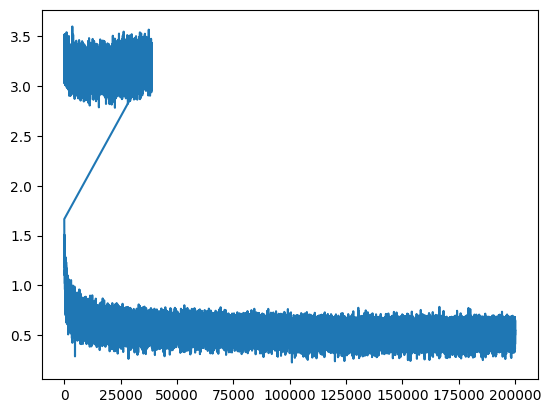

In [63]:
plt.plot(stepi, lossi)

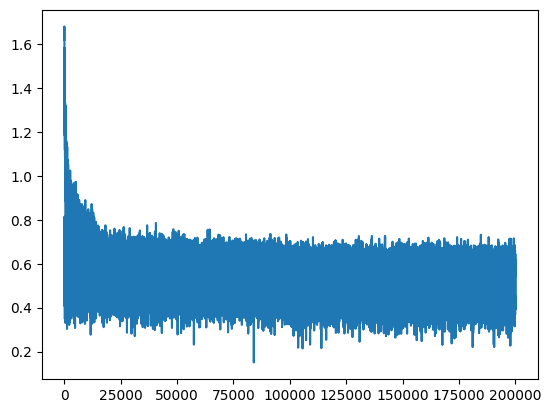

In [53]:
plt.plot(stepi, lossi)

In [54]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.3448, grad_fn=<NllLossBackward0>)

In [55]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.5948, grad_fn=<NllLossBackward0>)

/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2404 (\N{DEVANAGARI DANDA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython

/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2333 (\N{DEVANAGARI LETTER JHA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2338 (\N{DEVANAGARI LETTER DDHA}) missing from current font.
  func(*args, **kwargs)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/

/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2336 (\N{DEVANAGARI LETTER TTHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2364 (\N{DEVANAGARI SIGN NUKTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2338 (\N{DEVANAGARI LETTER DDHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/khandelia1000/.venv310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from

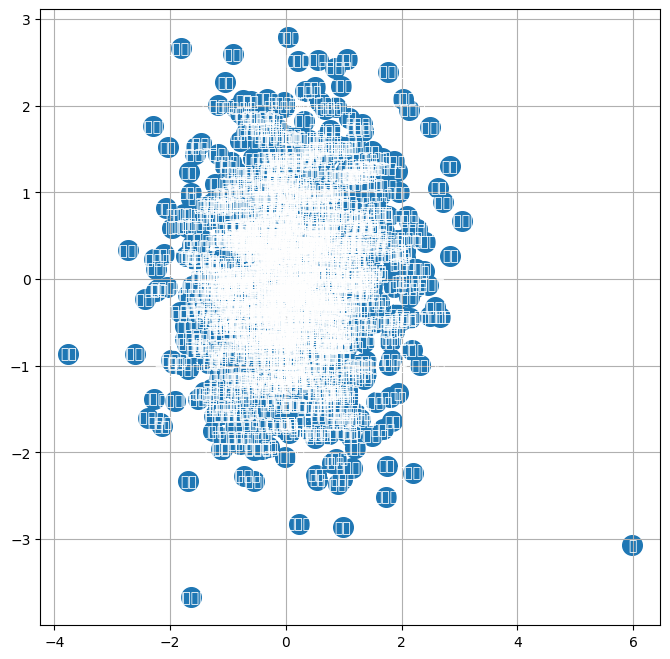

In [56]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [57]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [57]:
C.shape

(1296, 4)

In [59]:
params[0][jnp.array([0, 0, 0])].shape

(3, 10)

In [60]:
def get_probs(params, context):
    C, W1, b1, W2, b2 = params
    emb = C[jnp.array(context)]
    h = jnp.tanh(emb.reshape(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    return np.asarray(jax.nn.softmax(logits, axis=1))

In [62]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        probs = torch.from_numpy(get_probs(params, context))
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

अंरनल्ली।
मेमी।
कतलाल।
वदपत।
अवउदीन।
वाशुदीन।
सूरहन।
छमाश।
बल्तिर।
अकीबीर।
रगसिंह।
सशोका।
सैविलु।
तोकुमार।
सुमुदेई।
अद्दल।
रजोराम।
कोलनरायन।
कुखोनलाल।
मल्लोपाल।


In [49]:
probs.shape

torch.Size([32, 1296])